In [4]:
import fcsparser as fcs
import os
import pandas as pd
import warnings
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.utils import resample
import scipy.stats as stats
from socket import gethostname

sns.set(style="white")
sns.set_context("notebook")
warnings.filterwarnings("once")

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

tick_setup = {'labelsize' : SMALL_SIZE,
              'major.pad': 0}

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', **tick_setup)    # fontsize of the tick labels
plt.rc('ytick', **tick_setup)
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

hostname = gethostname().split('.')[0]
if hostname == 'Pluripa':
    home_dir = "/Users/weinberz/"
    box_dir = "/Users/weinberz/Box Sync/"
else:
    home_dir = "/Volumes/Coatamer/Users/weinberz/"
    box_dir = "/Volumes/Coatamer/Users/weinberz/Box/"

def gate_density (df, threshold, y_var='FSC-A', x_var='SSC-A'):
    
    ymin = df[y_var].min()
    ymax = df[y_var].max()
    xmin = df[x_var].min()
    xmax = df[x_var].max()
                                                                                                                                
    #Perform a kernel density estimate on the data:
    df_mini = df.sample(1000)
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([df_mini[x_var], df_mini[y_var]])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    cut = Z.max()*threshold
    
    # threhold dataframe
    df['gate'] = kernel([df[x_var], df[y_var]])
    df2 = df[df.gate > cut]
    return df2

In [5]:
outputdir = home_dir + "Google Drive/HES Lab/SARSNotch/SARSNotch Manuscript/jupyter_out/"

/opt/homebrew/Caskroom/miniforge/base/envs/flow/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
folder= box_dir + "BadIdea/Flow/20210329 - T Cell Spike/"

In [7]:
ffolderlist = [f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))]

df=pd.DataFrame()
aa=1
    #load all fcs files
for fdn in ffolderlist:
    ffilelist = os.listdir(folder+fdn)
    for fn in ffilelist:
        filename, file_ext = os.path.splitext(fn)
        if file_ext ==".fcs":
            path = folder + fdn + "//" + fn
            meta, df1 = fcs.parse(path, meta_data_only=False, reformat_meta=True)
            df1["WellName"]=fn.split("_")[3].split(".")[0]
            df1["WellNumber"]= aa
            df=df.append(df1)
            aa=aa+1

# metadata file
meta = folder+ "metadata.csv"
df1=pd.read_csv(meta, names=["WellName", "CellLine","Dose", 'Replicate'])

df=df1.merge(df, on=["WellName"])

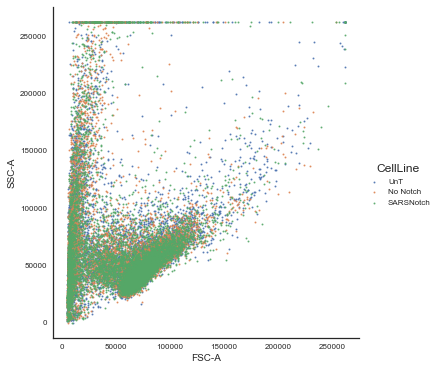

In [138]:
sns.lmplot(y="SSC-A", x="FSC-A", data=df[df["WellName"].isin(['A01','A04','A07'])], fit_reg=False, scatter_kws={'s': 1}, hue='CellLine')
plt.show()

In [8]:
#remove small events
df2 =df[df["FSC-A"]>5E4]
df2 =df2[df2["SSC-A"]>2.5E4]

#remove NAs
df2= df2.loc[(df2.select_dtypes(include=['number']) > 0).all(axis='columns'), :]
df2=df2.dropna()

#gate cells
df2 = gate_density(df2, 0.1)

#log data
for col in df2.columns:
    if df2[col].dtype=="float32":
        df2["log"+ col]=df2[col].apply(math.log10)

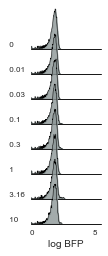

In [145]:
with sns.color_palette(["#8C9696"]):
    g = sns.FacetGrid(data=df2[(df2['CellLine'] == 'No Notch') &
                               (df2['logFITC-A'] > 2)],
                      row='Dose', sharey=False, aspect=3, height=0.45, 
                      row_order = [str(x) for x in [0,0.01,0.03,0.1,0.3,1,3.16, 10]],
                      hue_order = [str(x) for x in [0,0.01,0.03,0.1,0.3,1,3.16, 10]], xlim=[0, 5.5])
    g.map(sns.kdeplot, "logBV 421-A", shade=True, alpha=0.8, bw_adjust=0.2, cut=0)
    g.map(sns.kdeplot, "logBV 421-A", color="black", lw=0.5, bw_adjust=.2, cut=0)
    g.map(plt.axhline, y=0, lw=1, color='k', clip_on=False)

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.4)

    for ax in g.axes.flat:
        dose = ax.get_title().split("=")[1]
        ax.text(-0.35,0.1, "{}".format(dose), ha="left", va="center", 
                bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
        ax.set(facecolor=(0, 0, 0, 0))

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    plt.xlabel("log BFP")
    plt.savefig(outputdir+'tcell_no-notch_spike_histogram.svg')

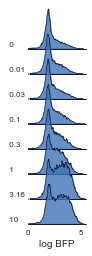

In [135]:
with sns.color_palette(["#4272B8"]):
    g = sns.FacetGrid(data=df2[(df2['CellLine'] == 'SARSNotch') &
                               (df2['logFITC-A'] > 4)],
                      row='Dose', sharey=False, aspect=3, height=0.45, 
                      row_order = [str(x) for x in [0,0.01,0.03,0.1,0.3,1,3.16, 10]],
                      hue_order = [str(x) for x in [0,0.01,0.03,0.1,0.3,1,3.16, 10]], xlim=[0, 5.5])
    g.map(sns.kdeplot, "logBV 421-A", shade=True, alpha=0.8, bw_adjust=0.2, cut=0)
    g.map(sns.kdeplot, "logBV 421-A", color="black", lw=0.5, bw_adjust=.2, cut=0)
    g.map(plt.axhline, y=0, lw=1, color='k', clip_on=False)

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.4)

    for ax in g.axes.flat:
        dose = ax.get_title().split("=")[1]
        ax.text(-0.35,0.1, "{}".format(dose), ha="left", va="center", 
                bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
        ax.set(facecolor=(0, 0, 0, 0))

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    plt.xlabel("log BFP")
    plt.savefig(outputdir+'tcell_lcb1-notch_spike_histogram.svg')

In [133]:
qt = np.percentile(df2[(df2['CellLine'] == 'No Notch') &
                       (df2['Dose'] == '0') &
                       (df2['logFITC-A'] > 4)]['logBV 421-A'],90)
summary = (df2[(df2['logFITC-A'] > 4)].groupby(['CellLine', 'Dose', 'Replicate'])['logBV 421-A']
              .apply(lambda x: 100*np.sum(x>qt)/len(x))
              .reset_index())
summary['Dose'] = pd.to_numeric(summary['Dose'])

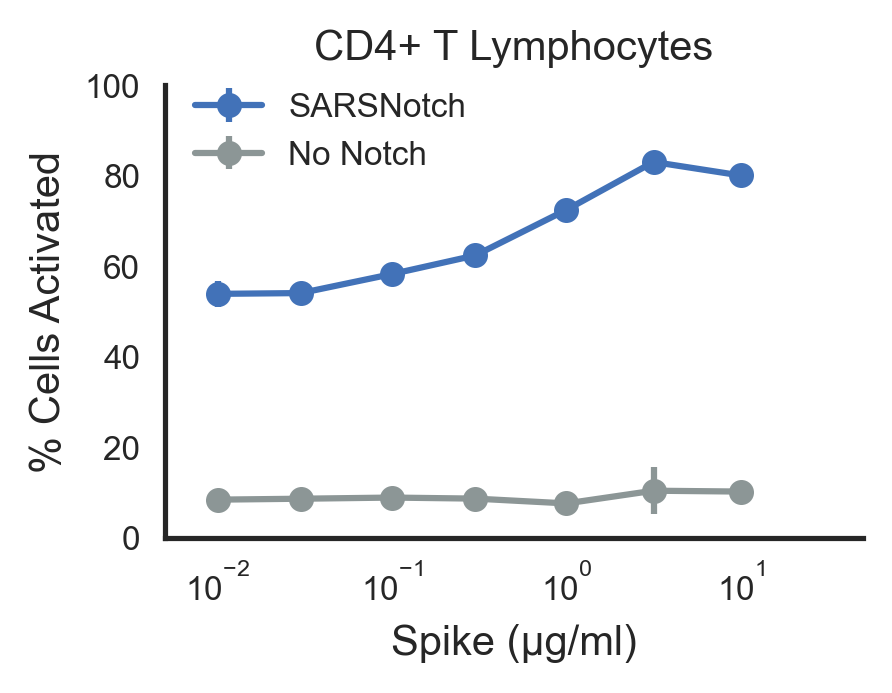

In [134]:
fig, ax = plt.subplots(1,1,figsize=(3,2), dpi=300)
for notch, color in zip(['No Notch', 'SARSNotch'],['#8C9696','#4272B8']):
    notch_summary = summary[(summary['CellLine']==notch) & (summary['Dose'] != 0)]
    output = notch_summary.groupby('Dose')['logBV 421-A'].agg([np.mean, np.std]).reset_index()
    ax.errorbar(output['Dose'], output['mean'], yerr=output['std'], fmt='-',marker='.', markersize=10, c=color, label=notch)

ax.set_xscale('log')
ax.set_xlim([0.005, 50])
ax.set_xlabel('Spike (µg/ml)')
ax.set_ylabel('% Cells Activated')
plt.legend()
handles, labels = ax.get_legend_handles_labels()
order = [1, 0]
plt.legend([handles[idx] for idx in order],
           [labels[idx] for idx in order],
           frameon=False, loc='upper left', bbox_to_anchor=(0,1.05))
plt.ylim([0,100])
sns.despine()
plt.title('CD4+ T Lymphocytes')
plt.savefig(outputdir + 'tcell_triplicate_dose.svg')

/opt/homebrew/Caskroom/miniforge/base/envs/flow/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


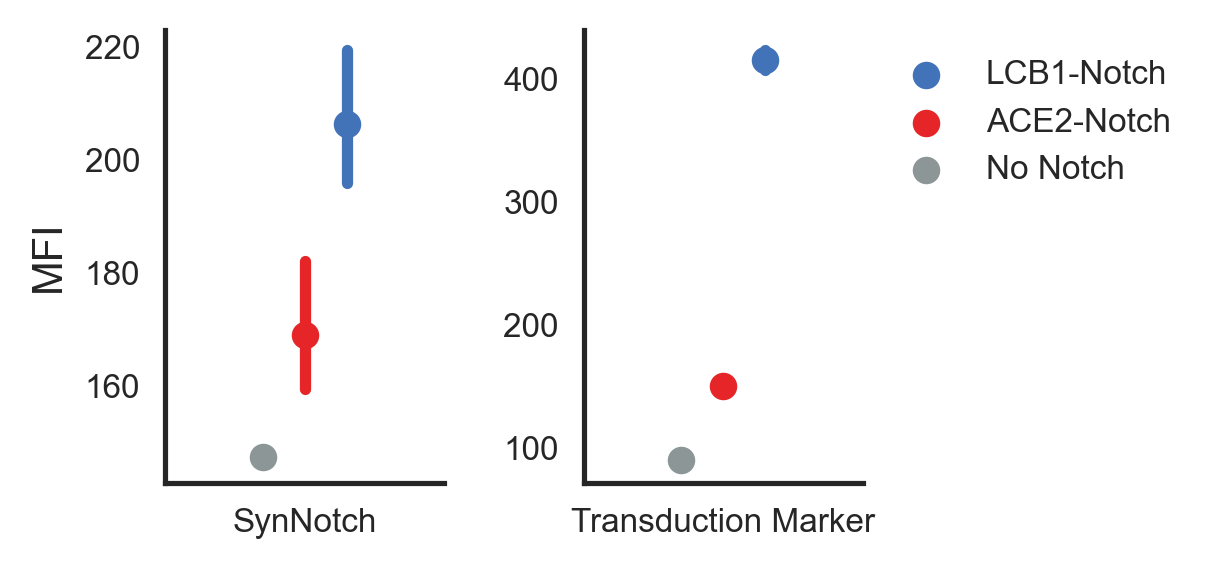

In [15]:
simplified_df = (df2[df2['logFITC-A'] > 5]
                 .reset_index()
                 .melt(value_vars=['PE-CF594-A','APC-A'], 
                       id_vars=['index','CellLine','Dose','Replicate'],
                       var_name='channel',
                       value_name='counts')
                 .reset_index()
                 .groupby(['CellLine','Dose','Replicate', 'channel'])['counts']
                 .mean()
                 .reset_index())

simplified_df.loc[simplified_df['channel'] == 'PE-CF594-A', 'channel'] = 'Transduction Marker'
simplified_df.loc[simplified_df['channel'] == 'APC-A', 'channel'] = 'SynNotch'

with sns.color_palette(['#8C9696',"#E52527", '#4272B8']):
    fig, axs = plt.subplots(1,2, figsize=(3, 2), dpi=300)
    for channel, ax in zip(['SynNotch', 'Transduction Marker'], axs):
        g = sns.pointplot(data=simplified_df[(simplified_df['CellLine']).isin(['No Notch', 'ACE2-Notch', 'LCB1-Notch']) &
                                             (simplified_df['channel'] == channel)], 
                          x='channel', y='counts', hue='CellLine',
                          hue_order=['No Notch', 'ACE2-Notch', 'LCB1-Notch'],
                          join=False, dodge=0.3, scale=0.75, ax=ax)
        g.legend().remove()
        g.set_xlabel('')
        g.set_ylabel('')
    axs[0].set_ylabel('MFI')
    handles, labels = axs[1].get_legend_handles_labels()
    order = [2, 1, 0]
    axs[1].legend([handles[idx] for idx in order],
                  [labels[idx] for idx in order],
                  frameon=False, loc='upper left', bbox_to_anchor=[1,1])
    plt.subplots_adjust(wspace=0.5)
    sns.despine()
    plt.savefig(outputdir + 'mfi_jurkats.svg')

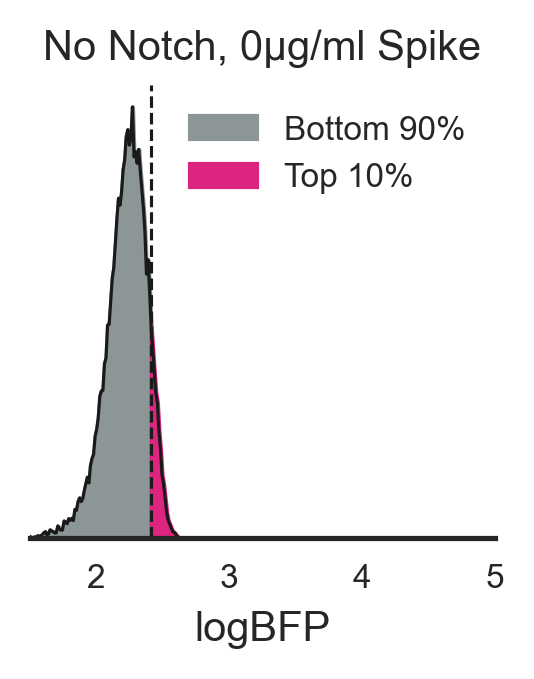

In [144]:
fig, ax = plt.subplots(1,1,figsize=(2,2), dpi=300)
subset = df2[(df2['CellLine'] == 'No Notch') &
             (df2['Dose'] == '0')].copy()
subset['Percentile'] = ['Top 10' if above_qt else 'Bottom 90' for above_qt in subset['logBV 421-A']>qt]
ax = sns.kdeplot(data=subset, x='logBV 421-A', shade=False, ax=ax, color='k', cut=0, bw_adjust=0.2, lw=0.76)
kde_x, kde_y = ax.lines[0].get_data()
ax.fill_between(kde_x, kde_y, where=(kde_x<qt) , 
                interpolate=True, color='#8C9696', label='Bottom 90%')
ax.fill_between(kde_x, kde_y, where=(kde_x>qt) , 
                interpolate=True, color='#DC257F', label='Top 10%')
plt.axvline(qt, c='k', ls='--', lw=0.75)
plt.xlim([1.5, 5])
plt.xlabel('logBFP')
plt.legend(frameon=False)
sns.despine(left=True)
plt.yticks([])
plt.ylabel('')
plt.title('No Notch, 0µg/ml Spike')
plt.savefig(outputdir + 'sample_90_quant.svg')

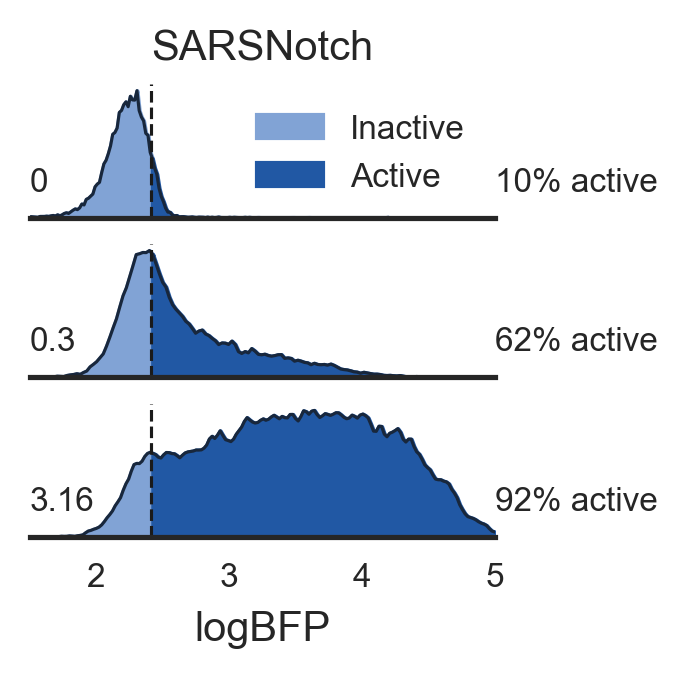

In [143]:
fig, axs = plt.subplots(3,1,figsize=(2,2), dpi=300)

for dose, ax in zip(['0', '0.3', '3.16'], axs):
    subset = df2[(df2['CellLine'] == 'LCB1-Notch') &
             (df2['Dose'] == dose)].copy()
    active = np.sum(subset['logBV 421-A'] > qt)/len(subset)
    sns.kdeplot(data=subset, x='logBV 421-A', shade=False, ax=ax, color='#18273C', cut=0, bw_adjust=0.2, lw=0.76)
    kde_x, kde_y = ax.lines[0].get_data()
    ax.fill_between(kde_x, kde_y, where=(kde_x<qt) , 
                interpolate=True, color='#81A3D5', label='Inactive')
    ax.fill_between(kde_x, kde_y, where=(kde_x>qt) , 
                interpolate=True, color='#2158A4', label='Active')
    ax.axvline(qt, c='k', ls='--', lw=0.75)
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.set(facecolor=(0, 0, 0, 0))
    ax.text(0, 0.2, dose, transform=ax.transAxes)
    ax.text(1, 0.2, f'{active*100:.0f}% active', transform=ax.transAxes)
    ax.set_xlim([1.5, 5])

plt.xlabel('logBFP')
axs[0].legend(frameon=False)
axs[0].set_title('SARSNotch')
for idx in [0,1]:
    axs[idx].set_xticks([])
    axs[idx].set_xlabel('')
sns.despine(left=True)
plt.savefig(outputdir + 'sample_90_quant_sarsnotch.svg')